In [1]:
import dataset
import importlib
importlib.reload(dataset)
from dataset import *
# keep this import code above this cell in every cell that loads data

import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(13)

# If you're using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(13)
    torch.cuda.manual_seed_all(13)

def linear_scheduler(t, T):
    beta_1 = 0.0001
    beta_T = 0.02
    return ((t-1)/(T-1))*(beta_T-beta_1)+beta_1

def cosine_scheduler(t, T):
    return torch.square(torch.cos((t+0.008)/1.008*torch.pi/2))

def const_scheduler(t, T):
    return 0.03

scheduler = linear_scheduler

USE_SCHEDULING = True
if USE_SCHEDULING is False:
    assert scheduler == const_scheduler

T = 400
# my_dataset = MyDataset(data='grid', T=T, nr_unique_img_without_noise=1, nr_noised_img_per_img_without_noise=10, grid_size=4, scheduling_fn=scheduler)
# my_dataset = MyDataset(data='mnist', T=T, grid_size=16, nr_unique_img_without_noise=1, nr_noised_img_per_img_without_noise=100, scheduling_fn=scheduler)
my_dataset = MyDataset(
    data='cifar10', 
    T=T, grid_size=32, nr_unique_img_without_noise=5000, scheduling_fn=scheduler)
my_dataloader = DataLoader(my_dataset, batch_size=1024, shuffle=True)

print(len(my_dataset), len(my_dataloader))

visualize(my_dataset.get_original_img(0))

plt.plot(torch.arange(T), cosine_scheduler(torch.arange(T), T))

Epoch [1/10], cost=5.0846481919288635
Epoch [1/10], cost=5.0846481919288635
Epoch [2/10], cost=4.427171885967255
Epoch [2/10], cost=4.427171885967255
Epoch [3/10], cost=3.8384311199188232
Epoch [3/10], cost=3.8384311199188232
Epoch [4/10], cost=3.2432583570480347
Epoch [4/10], cost=3.2432583570480347
Epoch [5/10], cost=2.729666590690613
Epoch [5/10], cost=2.729666590690613
Epoch [6/10], cost=2.237947255373001
Epoch [6/10], cost=2.237947255373001
Epoch [7/10], cost=1.8785568177700043
Epoch [7/10], cost=1.8785568177700043
Epoch [8/10], cost=1.5848264396190643
Epoch [8/10], cost=1.5848264396190643
Epoch [9/10], cost=1.3212478011846542
Epoch [9/10], cost=1.3212478011846542
Epoch [10/10], cost=1.141278937458992
Epoch [10/10], cost=1.141278937458992
Training finished.


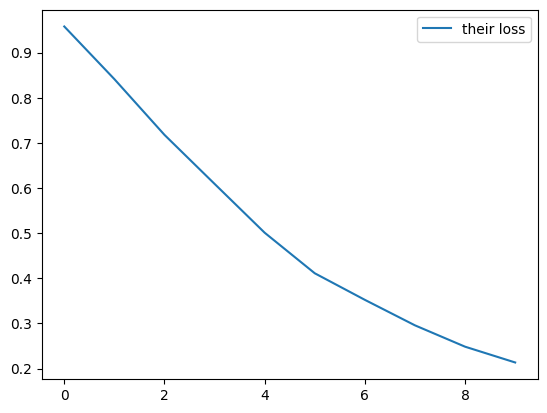

In [3]:
import models
importlib.reload(models)
from models import *
importlib.reload(dataset)
# keep this import code above this line in every training cell

import torch.optim as optim
import os
import time

model = UNet32(in_channels=my_dataset.nr_channels, out_channels=my_dataset.nr_channels, time_emb_dim=128, dropout=0.003)

model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

cost_arr = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (with_noise, t), standard_normal in my_dataloader:
        with_noise, t, standard_normal = with_noise.to(device), t.to(device), standard_normal.to(device)

        optimizer.zero_grad()

        t = t.view(-1)
        outputs = model(with_noise, t if USE_SCHEDULING else tf.tensor([0]).to(device))

        loss = criterion(outputs, standard_normal)

        elapsed_time = time.time() - start_time
        if elapsed_time >= 1800:
            save_path = os.path.join('/home/mls20/diffusion-implementation', f'model_epoch_{epoch}_batch_{epoch}.pth')
            torch.save(model.state_dict(), save_path)
            print(f'Model saved at {save_path}')
            start_time = time.time()  # Reset the start time
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    if num_epochs >= 10:
        if epoch % (num_epochs // 10) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], cost={running_loss}')
    print(f'Epoch [{epoch+1}/{num_epochs}], cost={running_loss}')

    cost_arr.append(loss.item())

print('Training finished.')

plt.plot(cost_arr, label='their loss')
plt.legend()
plt.show()

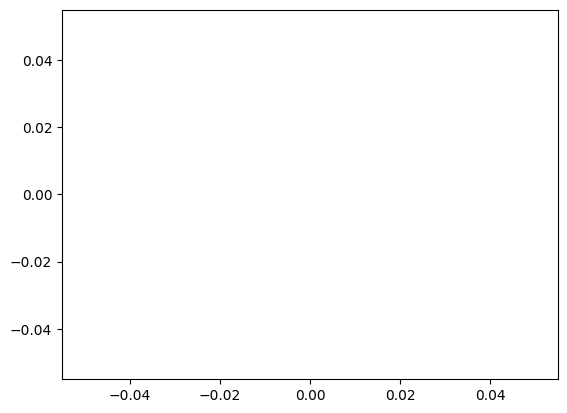

In [4]:
plt.plot(cost_arr[int(len(cost_arr)*0.9):-1])

32 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


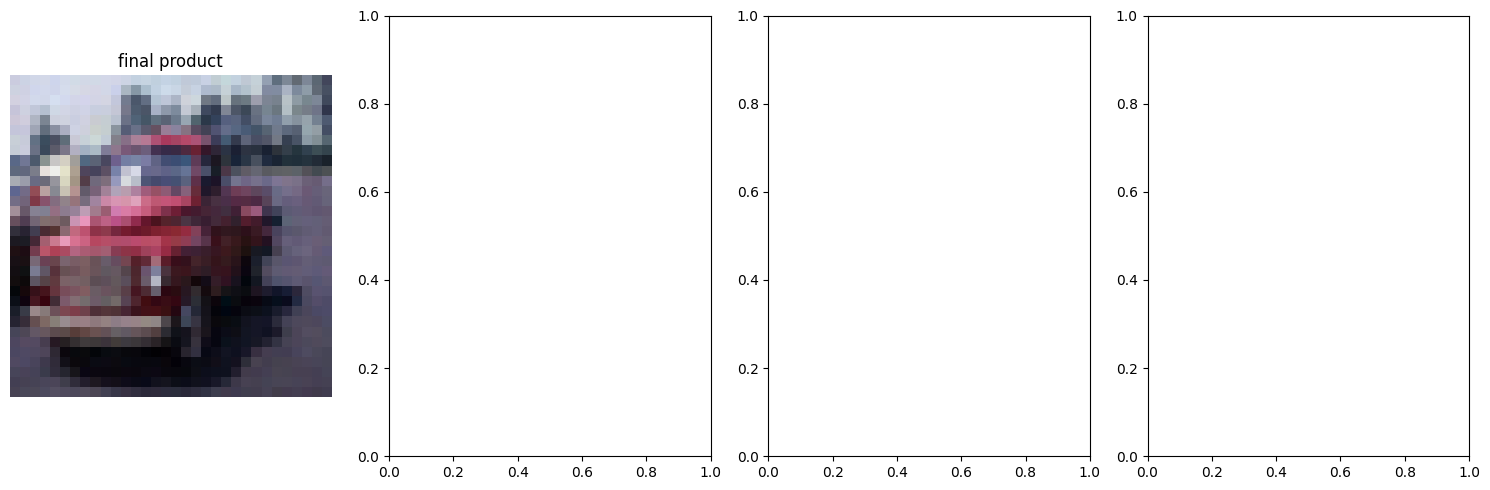

Sampling done. Now writing to .gif
<class 'list'>
torch.Size([3072])
401 400
nr_frames= 401 saving to:  1722680539.gif


In [61]:
import copy
import utils
importlib.reload(utils)
from utils import *

import time

def do_inference(noised_input : torch.tensor, T, model, return_denoise_intermediates=False):

    noised_input = noised_input.to(device)
    
    img = copy.deepcopy(noised_input)

    if return_denoise_intermediates:
        intermediates_arr = []
        intermediates_arr.append(copy.deepcopy(img))

    # precalculating this to avoid O(T^2) complexity and reduce to O(T)
    alpha_t_cum = np.empty(T+1)
    alpha_t_cum[0] = 1
    for t in range(1, T+1):
        beta_t = my_dataset.scheduling_fn(t, T)
        alpha_t = 1 - beta_t
        alpha_t_cum[t] = alpha_t_cum[t-1]*alpha_t

    model.eval()

    with torch.no_grad():
        for t in range(T, 0, -1): # go from T to 1, including 1, which will calculate x_o from the DDPM paper
            beta_t = my_dataset.scheduling_fn(t, T)
            alpha_t = 1 - beta_t

            c = (1 - alpha_t) / np.sqrt(1 - alpha_t_cum[t])
            assert(1 - alpha_t_cum[t] >= 0), (alpha_t_cum[t], t)
            # random = torch.randn(img.shape) * get_beta_t(t)/20 # temp
            # random = 0 # temp BUT TURN OFF AT T=1,0 I THING. It says in the paper
            new_shape = (1, my_dataset.nr_channels, my_dataset.grid_size, my_dataset.grid_size)
            img = img.view(new_shape)

            k = torch.tensor([0 if t <= 1 else np.sqrt(beta_t)], dtype=img.dtype).to(device)
            random = (torch.randn(img.shape).to(device)*k).to(device)

            # print(img.shape)
            model_output = model(img, torch.tensor([t if USE_SCHEDULING else 0]).to(device)).view(new_shape)
            img = 1/np.sqrt(alpha_t) * (img - model_output * c) + random # calculates x_{t-1} from the DDPM paper

            if return_denoise_intermediates:
                intermediates_arr.append(copy.deepcopy(img))
    
    model.train()

    if return_denoise_intermediates is False:
        return img
    else:
        return img, intermediates_arr

def visualize_inference(dataset, model, T, sample_indices=None, return_intermediates_arr=False):
    # if sample_indices is None, then it generates a completely new image

    if return_intermediates_arr:
        intermediates_arr = []

    if sample_indices is None:
        generate_from_pure_random = True
        sample_indices = [0]
    else:
        generate_from_pure_random = False

    for i in sample_indices:

        if generate_from_pure_random is False:
            (noised, _), standard_gausian = my_dataset[i]
            original_img = my_dataset.get_original_img(i)
        else:
            gs, nc = dataset.grid_size, dataset.nr_channels
            print(gs, nc)
            noised = torch.randn((gs, gs, nc)).view(-1)

        # Perform inference
        inferred_img, intermediates = do_inference(noised, T, model, return_denoise_intermediates=return_intermediates_arr)

        # Plot the images
        # fig, axes = plt.subplots(1, 1 if generate_from_pure_random else 4, figsize=(15, 5))
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))

        gs, nc = my_dataset.grid_size, my_dataset.nr_channels
        
        final_product_ind = 0 if generate_from_pure_random  or True else 2
        axes[final_product_ind].imshow(intermediates[-1].view(gs, gs, nc).cpu().numpy(), vmin=0, vmax=1, interpolation='none')
        axes[final_product_ind].set_title(f'final product')
        axes[final_product_ind].axis('off')
            
        #if  generate_from_pure_random is False:
        if  False:
            pass
            # axes[0].imshow(original_img.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
            # axes[0].set_title('Original Image')
            # axes[0].axis('off')

            # axes[1].imshow(standard_gausian.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
            # axes[1].set_title('standard gausian used to generate noise')
            # axes[1].axis('off')
            

            # axes[3].imshow(noised.view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')
            # axes[3].set_title(f'Noised Image (t={my_dataset.t_arr[i]})')
            # axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # if T < 10: # dont print if there is too many frames
        #     fig, axes = plt.subplots(1, len(intermediates), figsize=(15, 5))
        #     for i, denoised_intermediate in enumerate(intermediates):
        #         axes[i].imshow(denoised_intermediate.cpu().numpy().view(gs, gs, nc), vmin=0, vmax=1, interpolation='none')

        #         axes[i].set_title(r'$x_{'+str(T-i)+r'}$')

        #         axes[i].axis('off')

            # for i in range(4):
            #     print()

        if return_intermediates_arr:
            intermediates_arr.append(intermediates)

    if return_intermediates_arr:
        return intermediates_arr

#intermediates_arr = visualize_inference(my_dataset, model, T=T, sample_indices=[0, 10, 20, 30, 40, 50], return_intermediates_arr=True)
intermediates_arr = visualize_inference(my_dataset, model, T=T, return_intermediates_arr=True)

print('Sampling done. Now writing to .gif')
print(type(intermediates_arr))
print(intermediates_arr[0][0].shape)
tensors_to_gif(intermediates_arr[0], str(int(time.time()))+'.gif', total_duration=0.005, grid_size=my_dataset.grid_size, nr_channels=my_dataset.nr_channels, T=T)

In [ ]:
for i in range(64):
    visualize(my_dataset.get_original_img(i))

In [6]:
save_path = 'model_epoch_26354_batch_26354.pth'
state_dict = torch.load(save_path, map_location=device)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

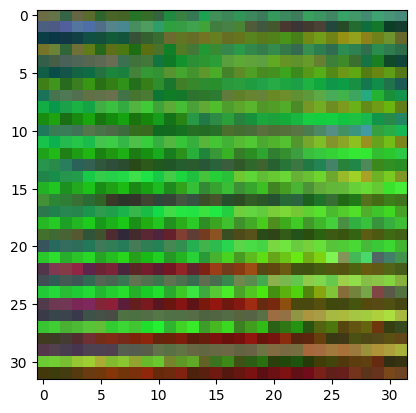

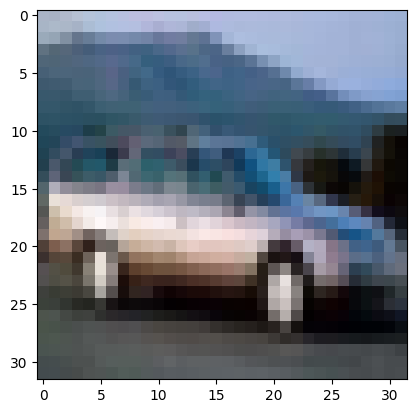

torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 32, 3])
torch.Size([32, 32, 3]) torch.Size([32, 

In [60]:
from skimage.metrics import structural_similarity as ssim

def a(output_image):
    def compute_ssim(image1, image2):
        return ssim(image1, image2, multichannel=True, channel_axis=2, data_range=1.0)
    
    
    output_image = output_image.view(my_dataset.nr_channels, my_dataset.grid_size, my_dataset.grid_size).cpu()
    output_image = output_image.permute(1, 2, 0)
    
    visualize(output_image)
    
    max_ssim = 0
    for i in range(my_dataset.nr_samples):
        dataset_image = my_dataset.get_original_img(i)

        if i == 0:
            visualize(dataset_image)

        print(output_image.shape, dataset_image.shape)
        
        similarity = compute_ssim(output_image.numpy(), dataset_image.numpy())
        if similarity > max_ssim:
            max_ssim = similarity
            closest_image = dataset_image
            idx = i
    
    # visualize(closest_image)
    return i

i = a(intermediates_arr[0][-1])
# visualize(my_dataset.get_original_img(i))

In [38]:
def get_cost(model):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for (with_noise, t), standard_normal in my_dataset:
            with_noise, t, standard_normal = with_noise.to(device), t.to(device), standard_normal.to(device)
    
            optimizer.zero_grad()
    
            t = t.view(-1)
            outputs = model(with_noise, t if USE_SCHEDULING else tf.tensor([0]).to(device))
    
            loss = criterion(outputs, standard_normal)
    
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    
    return running_loss

print(get_cost(model))

RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [3] and input of shape [3, 32, 32]